In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# we import useful libraries
import time
from robot_properties_nyu_finger.wrapper import NYUFingerDoubleRobot
from bullet_utils.env import BulletEnv
import numpy as np
import pybullet
import pinocchio as pin
import matplotlib
import matplotlib.pyplot as plt

In [3]:
# ! Create a Pybullet simulation environment before any robots !
env = BulletEnv()

# Create a robot instance. This adds the robot to the simulator as well.
robot = NYUFingerDoubleRobot()

# Add the robot to the env to update the internal structure of the robot
# at every simulation steps.
env.add_robot(robot)

In [4]:
def PD_control(P, D, des_pos, cur_pos, des_vel, cur_vel):
    '''
    calculate the joint torques
    '''
    error = des_pos - cur_pos # the position error for all the joints (it's a 3D vector)
    d_error = des_vel - cur_vel # the velocity error for all the joints
    
    # we compute the desired torques as a PD controller
    torque = P * error + D * d_error
    
    return torque

In [5]:
class robot_info:
    def __init__(self, model, data):
        self.model = model
        self.data = data
        self.ee0_id = model.getFrameId("finger0_lower_to_tip_joint")
        self.ee1_id = model.getFrameId("finger1_lower_to_tip_joint")
    
    def update(self, q, dq):
        pin.forwardKinematics(self.model, self.data, q, dq)
        
        self.ee0_pose = pin.updateFramePlacement(self.model, self.data, self.ee0_id)
        self.ee1_pose = pin.updateFramePlacement(self.model, self.data, self.ee1_id)
   
        self.body_jacobian_ee0 = pin.computeFrameJacobian(self.model, self.data, q, self.ee0_id)
        self.body_jacobian_ee1 = pin.computeFrameJacobian(self.model, self.data, q, self.ee1_id)

        self.R_ee0 = self.ee0_pose.rotation
        self.R_ee1 = self.ee1_pose.rotation

        self.Ad0 = np.zeros((6, 6))
        self.Ad0[:3, :3] = self.R_ee0
        self.Ad0[3:, 3:] = self.R_ee0

        self.Ad1 = np.zeros((6, 6))
        self.Ad1[:3, :3] = self.R_ee1
        self.Ad1[3:, 3:] = self.R_ee1

        self.oriented_jacobian_ee0 = self.Ad0 @ self.body_jacobian_ee0
        self.oriented_jacobian_ee1 = self.Ad1 @ self.body_jacobian_ee1

        self.Jov0 = self.oriented_jacobian_ee0[:3, :3]
        self.Jov1 = self.oriented_jacobian_ee1[:3, :3]

In [10]:
run_time = 2.0
center = [0, 0, 0]
radius = 0.05
plotting = True
'''
draw a circle in the xz plane
center (list): center of the circle
radius (float): radius of the circle
run_time (int): runtime in seconds
return:
'''
# initialize robot
# TODO: might not want to reset state
robot.reset_state(np.zeros(robot.nq), np.zeros(robot.nv))

# initialize robot info
ri = robot_info(robot.pin_robot.model, robot.pin_robot.data)

import time
time.sleep(0.5)

# set gain, d values for robot 0
gain = 2.
D = np.array([0.3, 0.3, 0.3])


# 1 ms for each step
dt = 0.001
num_steps = int(run_time/dt)

if plotting:
    # we store information
    # here we create some arrays that we use to store data generated during the control loop
    measured_positions = np.zeros([num_steps,3]) # will store the measured position
    measured_velocities = np.zeros_like(measured_positions) # will store the measure velocities

    desired_torques = np.zeros_like(measured_positions) # will store the commands we send to the robot
    desired_positions = np.zeros_like(measured_positions) # will store the desired positions we use in the PD controller
    desired_velocities = np.zeros_like(measured_positions) # will store the desired velocities

    reference_foot_positions = np.zeros([num_steps, 3])
    reference_foot_velocities = np.zeros([num_steps, 3])

    simulation_time = np.zeros([num_steps]) # will store the running time

    x_pos = np.zeros([num_steps]) # will store the x position of the foot (as computed by Forw. Kin.)
    y_pos = np.zeros([num_steps]) # will store the y position of the foot (as computed by Forw. Kin.)
    z_pos = np.zeros([num_steps]) # will store the z position of the foot (as computed by Forw. Kin.)

    x_vel = np.zeros([num_steps]) # will store the x velocity of the foot
    y_vel = np.zeros([num_steps]) # will store the y velocity of the foot
    z_vel = np.zeros([num_steps]) # will store the z velocity of the foot


# now we can enter the main control loop (each loop is 1 control cycle)
for i in range(num_steps):

    # we get the position and velocities of the joints and save them
    q, dq = robot.get_state()
    
    ########################------------------------------------
    # PD control for robot 1
    if i == 0:
        P2 = np.array([4,4,3])
        D2 = np.array([.5,.4,.2])
        # set up center in the first time
        q_des2 = np.array([0,0,np.pi/2.])
        dq_des2 = np.zeros_like(q_des2)
    
    joint_torques1 = PD_control(P2, D2, q_des2, q[3:], dq_des2, dq[3:])
    #########################---------------------------------------------
    
    # get end-effector position and Jacobian
    ri.update(q, dq)
    Jov = ri.Jov0

    # only want to control robot 0
    q = q[:3]
    dq = dq[:3]
    # measured position
    x_measured = ri.ee0_pose.translation
    
    if i == 0:
        # setup the center of circular movement
        print(x_measured, "first")
        # set up center in the first time
        center[0] = x_measured[0]
        center[1] = x_measured[1] - 0.3
        center[2] = x_measured[2] + 0.05

    t = dt * i
    w = np.pi
    
    # calculate desire position
    x_ref = np.array([center[0],
                      center[1] + radius * np.sin(w * t),
                      center[2] + radius * np.cos(w * t)])
    dx_ref = np.array([0.,
                       radius * w * np.cos(w * t),
                       -radius * w * np.sin(w * t)])

    # calculate inverse Jacobian
    if np.abs(q[2] < 0.05):
        Jov_inv = np.linalg.pinv(Jov + 1e-4*np.eye(3))
    else:
        Jov_inv = np.linalg.pinv(Jov)

    # calculate torque
    dx_des = dx_ref + gain * (x_ref - x_measured)
    dq_des = Jov_inv @ dx_des        
    d_error = dq_des - dq  # the velocity error for all the joints
    # we compute the desired torques as a PD controller
    joint_torques0 = D * d_error
        
    # we send them to the robot and do one simulation step
    robot.send_joint_command(np.append(joint_torques0, joint_torques1))
    env.step(sleep=True)
    
    if plotting:
        measured_positions[i,:] = q[:3]
        measured_velocities[i,:] = dq[:3]
        simulation_time[i] = dt * i
        x_pos[i], y_pos[i], z_pos[i] = x_measured
        reference_foot_positions[i] = x_ref
        reference_foot_velocities[i] = dx_ref
        x_vel[i], y_vel[i], z_vel[i] = Jov @ dq
        desired_positions[i,:] = q # there is no desired joint position so we just store the current one
        desired_velocities[i,:] = dq_des
        desired_torques[i,:] = joint_torques0

[-0.051 -0.059  0.05 ] first


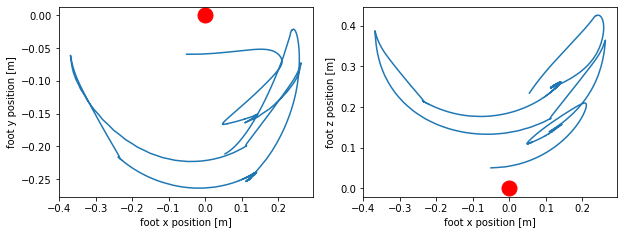

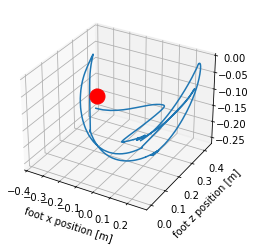

In [7]:
l0 = 0.3
l1 = 0.16
l2 = 0.16
l3 = 0.014

def plot_foot_trajectory(x_pos, y_pos, z_pos):
    """
    plots the position of the foot in 2D and the position of the spatial frame {s}
    we assume that the time varying x variable is in x_pos and that the y variable is in y_pos
    """    
    fig = plt.figure(figsize=(10,3.5))
    plt.subplot(1,2,1)
    plt.plot(x_pos,y_pos)
    plt.xlabel('foot x position [m]')
    plt.ylabel('foot y position [m]')
    plt.plot([0],[0],'o',markersize=15,color='r')
    
    plt.subplot(1,2,2)
    plt.plot(x_pos,z_pos)
    plt.xlabel('foot x position [m]')
    plt.ylabel('foot z position [m]')
    plt.plot([0],[0],'o',markersize=15,color='r')
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot3D(x_pos,z_pos,y_pos)
    plt.xlabel('foot x position [m]')
    plt.ylabel('foot z position [m]')
    ax.plot3D([0],[0],[0],'o',markersize=15,color='r')
    
plot_foot_trajectory(x_pos, y_pos, z_pos)

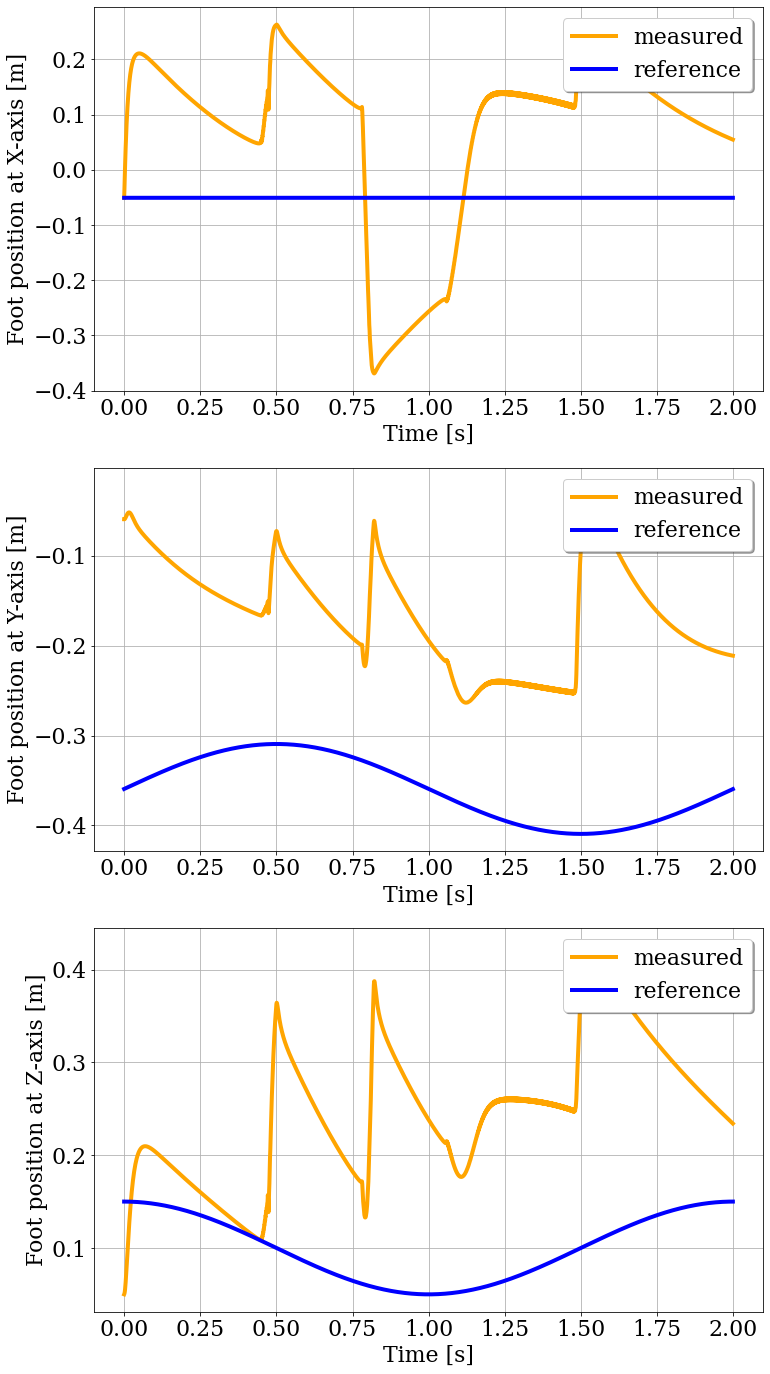

In [8]:
font = {'family' : 'serif',
        'size'   : 22}

matplotlib.rc('font', **font)
np.set_printoptions(precision=3, linewidth=200, suppress=True)

def plot_foot_positions(t, measured_foot_positions, desired_foot_positions):
    fig, ax = plt.subplots(3, 1, figsize=(12, 8*3))
    labels = ['X', 'Y', 'Z']

    for i in range(3):
        ax[i].plot(simulation_time, measured_foot_positions[:, i], 
                   lw=4, color='orange',
                   label='measured')
        ax[i].plot(simulation_time, desired_foot_positions[:, i], 
                   lw=4, color='blue',
                   label='reference')

        ax[i].grid()
        ax[i].set_xlabel('Time [s]')
        ax[i].set_ylabel(f'Foot position at {labels[i]}-axis [m]' )
        _ = ax[i].legend(loc='upper right', ncol=1, fancybox=True, shadow=True)
        
measured_foot_positions = np.vstack((x_pos, y_pos, z_pos)).T
plot_foot_positions(simulation_time, measured_foot_positions, reference_foot_positions)


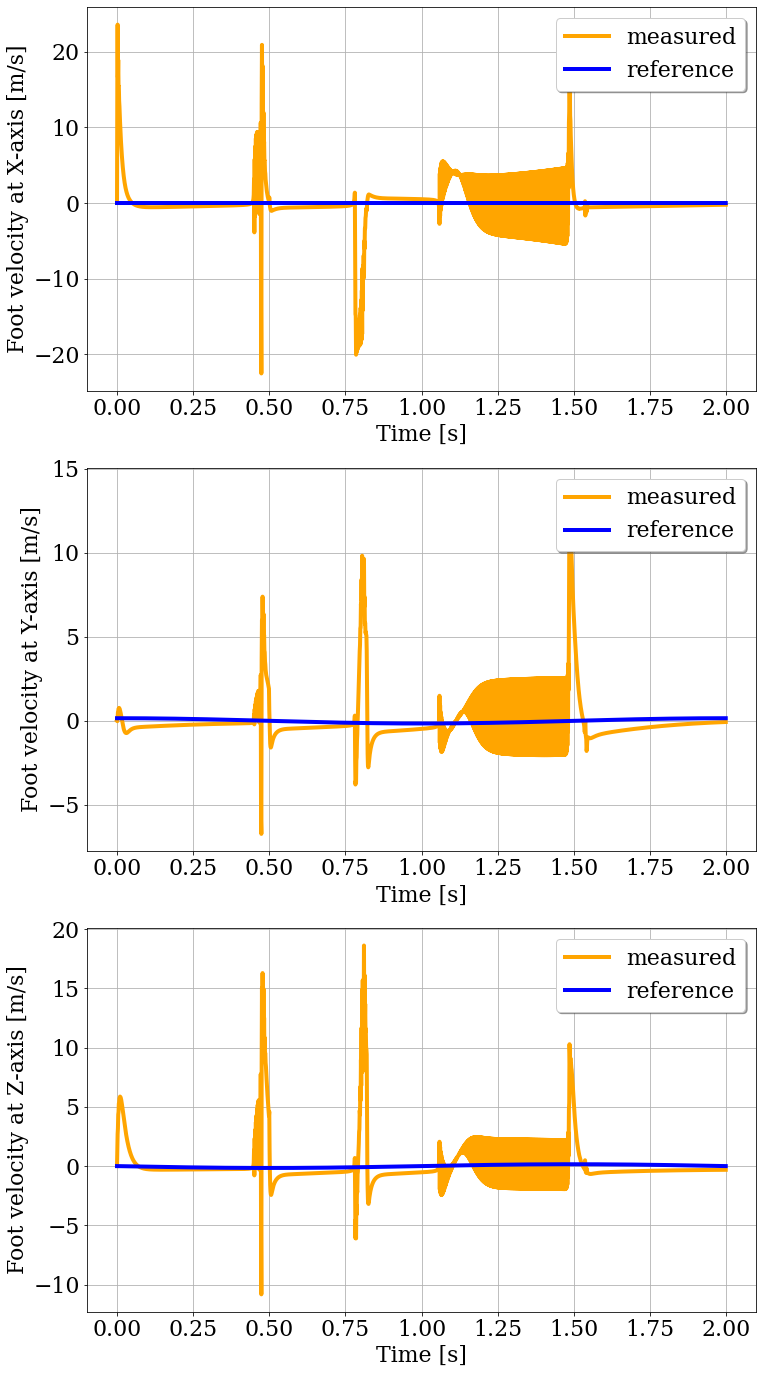

In [9]:

def plot_foot_velocities(t, measured_foot_velocities, desired_foot_velocities):
    fig, ax = plt.subplots(3, 1, figsize=(12, 8*3))
    labels = ['X', 'Y', 'Z']

    for i in range(3):
        ax[i].plot(simulation_time, measured_foot_velocities[:, i], 
                   lw=4, color='orange',
                   label='measured')
        ax[i].plot(simulation_time, desired_foot_velocities[:, i], 
                   lw=4, color='blue',
                   label='reference')

        ax[i].grid()
        ax[i].set_xlabel('Time [s]')
        ax[i].set_ylabel(f'Foot velocity at {labels[i]}-axis [m/s]' )
        _ = ax[i].legend(loc='upper right', ncol=1, fancybox=True, shadow=True)

measured_foot_velocities = np.vstack((x_vel, y_vel, z_vel)).T
plot_foot_velocities(simulation_time, measured_foot_velocities, reference_foot_velocities)